[参考](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)。

该脚本还显示了各个模型的常用参数。

In [49]:
import pandas as pd
import numpy as np

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

PassengerId = test['PassengerId']

In [50]:
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

In [51]:
# nan 的 type 是 float
# Cabin- 客舱号，C85、C123 这样的
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [53]:
train[['Name', 'Name_length', 'Cabin', 'Has_Cabin']].head()

,Name,Name_length,Cabin,Has_Cabin
0,"Braund, Mr. Owen Harris",23,NaN,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",51,C85,1
2,"Heikkinen, Miss. Laina",22,NaN,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",44,C123,1
4,"Allen, Mr. William Henry",24,NaN,0


到此为止，增加了 $2$ 个特征。

In [6]:
# 合并在一起
full_data = [train, test]

In [54]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [55]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

又增加了两个特征 FamilySize 和 IsAlone。

填充缺失值。

In [56]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [57]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [58]:
# cut 将根据值本身来选择箱子均匀间隔，qcut 是根据这些值的频率来选择箱子的均匀间隔
train['CategoricalFare'], bins = pd.qcut(train['Fare'], 4, retbins=True)
bins

array([  0.    ,   7.9104,  14.4542,  31.    , 512.3292])

In [59]:
pd.cut(train['Fare'], bins=bins).value_counts()

(7.91, 14.454]     224
(31.0, 512.329]    222
(14.454, 31.0]     222
(0.0, 7.91]        208
Name: Fare, dtype: int64

In [60]:
train[['Fare', 'CategoricalFare']].head()

,Fare,CategoricalFare
0,7.2500,"(-0.001, 7.91]"
1,71.2833,"(31.0, 512.329]"
2,7.9250,"(7.91, 14.454]"
3,53.1000,"(31.0, 512.329]"
4,8.0500,"(7.91, 14.454]"


随机填充 Age 缺失字段。

In [14]:
# 用训练集和测试集各自 Age 字段的均值和方差随机填充 Age 字段
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(
        age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

In [15]:
train['CategoricalAge'], bins = pd.cut(train['Age'], 5, retbins=True)
bins

array([-0.08, 16.  , 32.  , 48.  , 64.  , 80.  ])

In [16]:
import re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [17]:
# 把 title 提取出来，然后再合并
for dataset in full_data:
    dataset['Title'] = dataset['Name'].map(get_title)

In [18]:
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [19]:
# Mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
Embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1})

    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map(Embarked_mapping)

    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454),
                'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31),
                'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [20]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

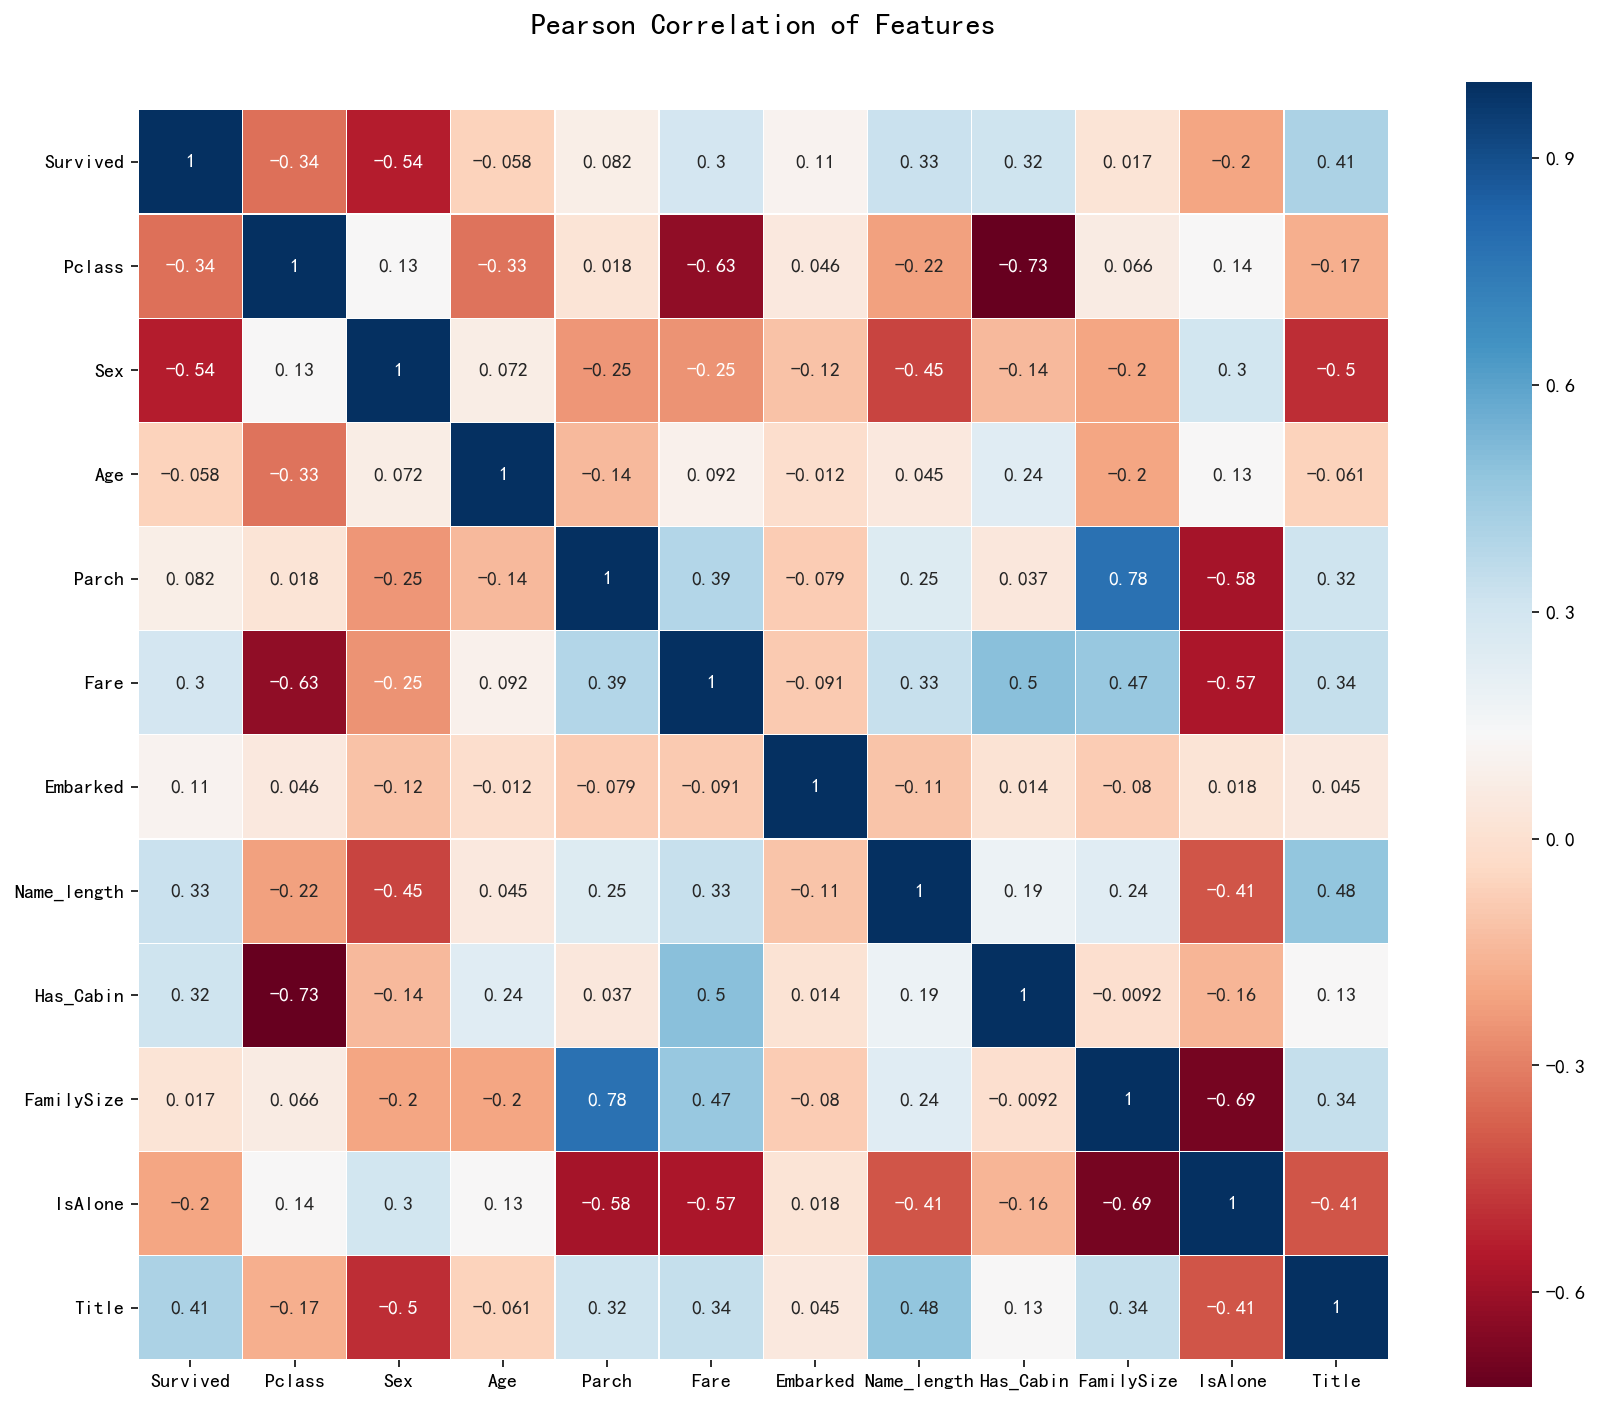

In [21]:
import seaborn as sns

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(
    train.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0,
    square=True,
    cmap=colormap,
    linecolor='white',
    annot=True)

plt.show()

In [47]:
train.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,1,0,0,0,23,0,2,0,1
1,1,0,2,0,3,1,51,1,2,0,3
2,3,0,1,0,1,0,22,0,1,1,2
3,1,0,2,0,3,0,44,1,2,0,3
4,3,1,2,0,1,0,24,0,1,1,1


In [48]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3


把离散变量处理成连续变量，这样就不会出现独热编码，特征数量增多。

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


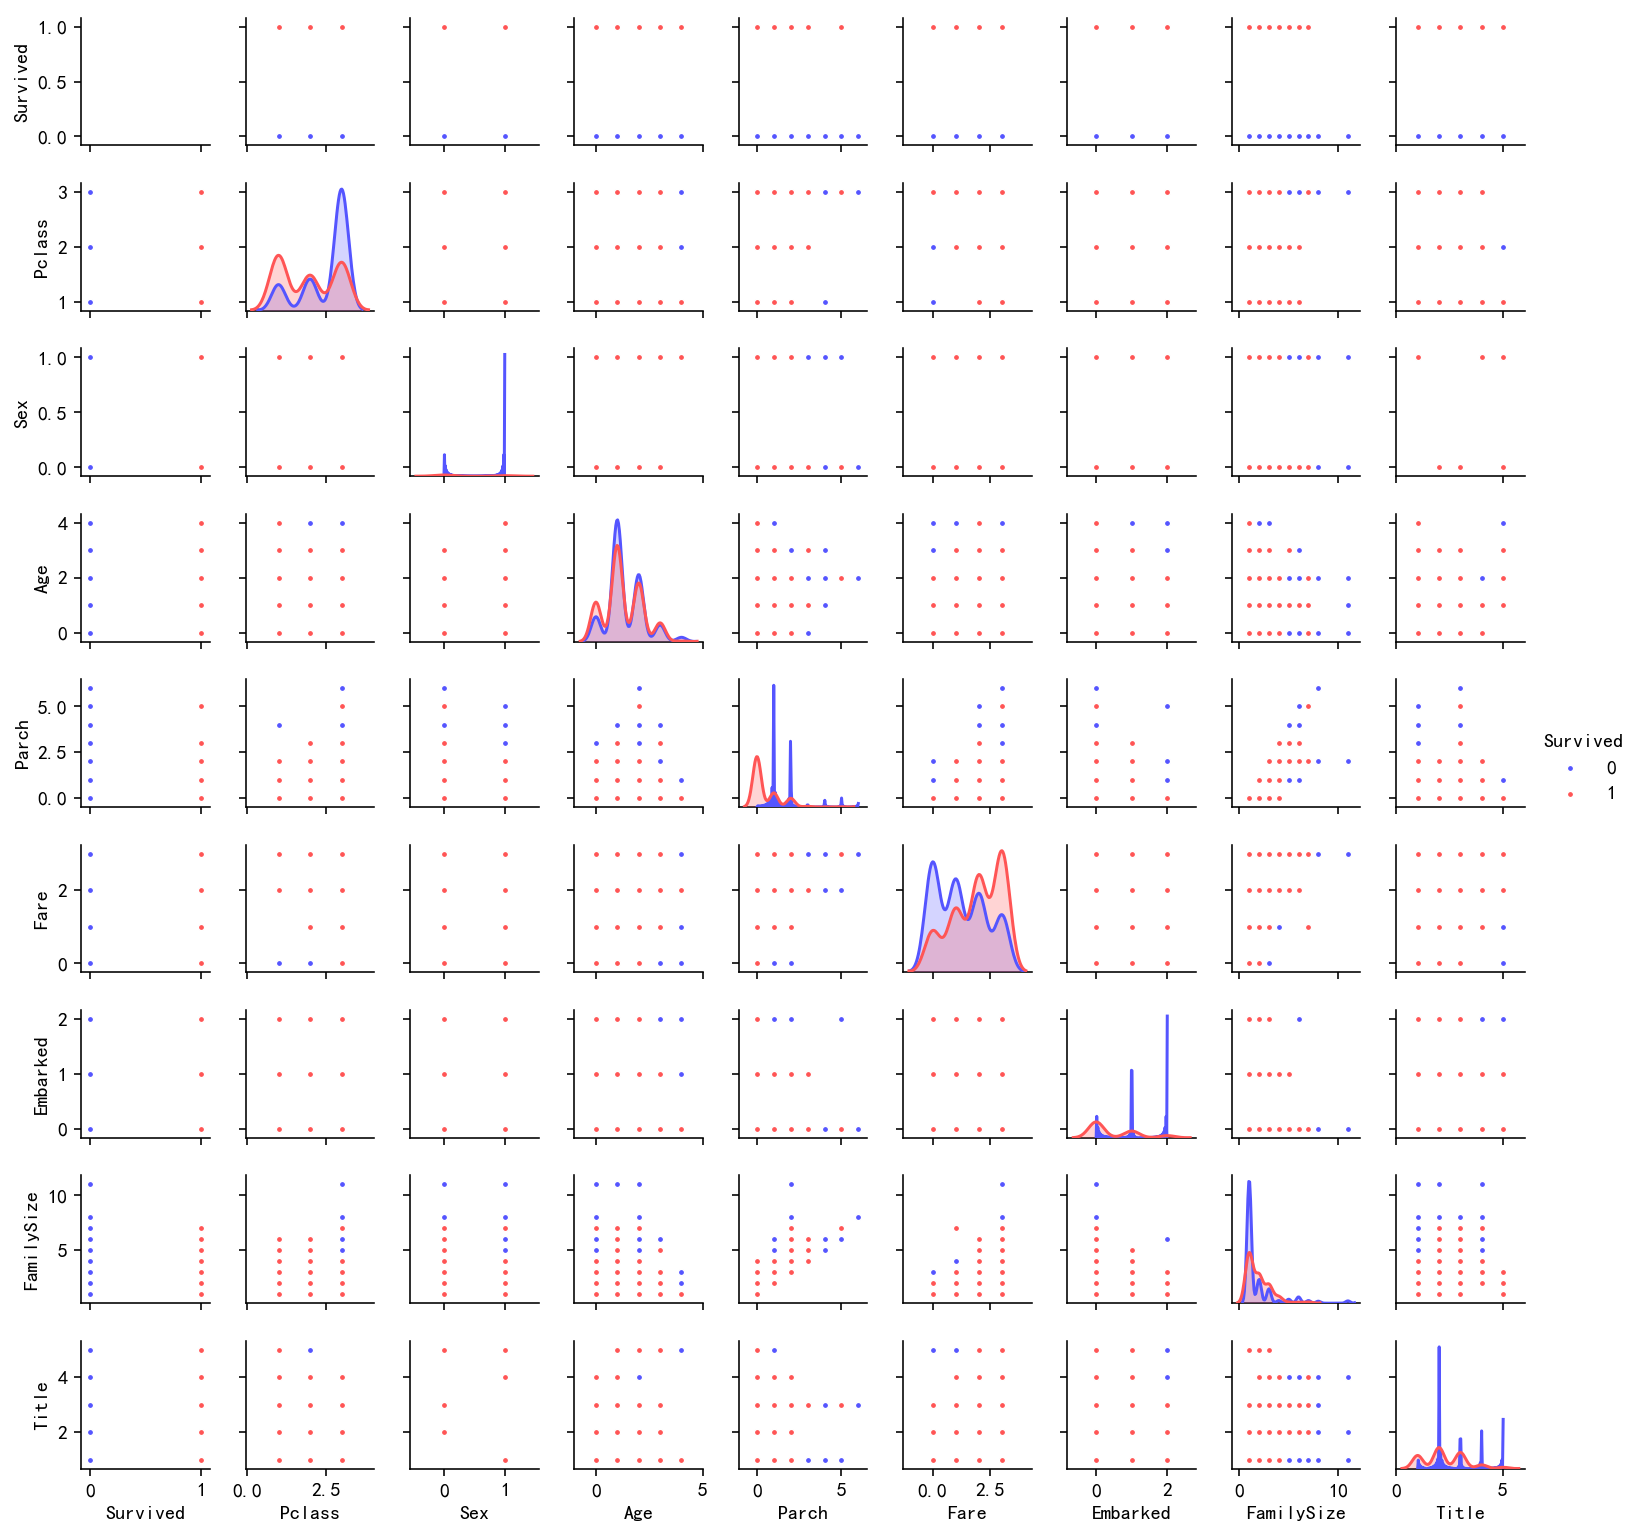

In [22]:
g = sns.pairplot(
    train[[
        'Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
        'FamilySize', 'Title'
    ]],
    hue='Survived',
    palette='seismic',
    size=1.2,
    diag_kind='kde',
    diag_kws=dict(shade=True),
    plot_kws=dict(s=10))
# g.set(xticklabels=[])
plt.show()

In [23]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0  # for reproducibility
NFOLDS = 5  # set folds for out-of-fold prediction

In [24]:
from sklearn.model_selection import KFold

kf = KFold(NFOLDS, random_state=SEED)

In [25]:
# Class to extend the Sklearn classifier
class SklearnHelper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_


# Class to extend XGboost classifer

In [26]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [27]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [28]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [29]:
import xgboost as xgb

In [30]:
# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC

# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [31]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train,
                                    x_test)  # Random Forest
et_oof_train, et_oof_test = get_oof(et, x_train, y_train,
                                    x_test)  # Extra Trees

ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train,
                                      x_test)  # AdaBoost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train,
                                    x_test)  # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train,
                                      x_test)  # Support Vector Classifier

print("Training is complete")

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


In [32]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


In [33]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [34]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.127280,0.119806,0.034,0.084834
1,Sex,0.200025,0.377438,0.014,0.008263
2,Age,0.032691,0.032625,0.014,0.057201
3,Parch,0.020720,0.016721,0.062,0.015266
4,Fare,0.071551,0.055010,0.036,0.054828
5,Embarked,0.023267,0.028506,0.008,0.025107
6,Name_length,0.109875,0.047334,0.698,0.173831
7,Has_Cabin,0.063748,0.082972,0.014,0.037695
8,FamilySize,0.066583,0.045711,0.048,0.110711
9,IsAlone,0.013019,0.022128,0.004,0.004713


In [35]:
import re
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt

import plotly.tools as tls

In [36]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Scatter plot
trace = go.Scatter(
    y=feature_dataframe['Random Forest feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        #       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color=feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values)
data = [trace]
layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',
    #     xaxis= dict(
    #         title= 'Pop',
    #         ticklen= 5,
    #         zeroline= False,
    #         gridwidth= 2,
    #     ),
    yaxis=dict(title='Feature Importance', ticklen=5, gridwidth=2),
    showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [37]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [38]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [39]:
# Scatter plot
trace = go.Scatter(
    y=feature_dataframe['Gradient Boost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        #       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color=feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Gradient Boosting Feature Importance',
    hovermode='closest',
    #     xaxis= dict(
    #         title= 'Pop',
    #         ticklen= 5,
    #         zeroline= False,
    #         gridwidth= 2,
    #     ),
    yaxis=dict(title='Feature Importance', ticklen=5, gridwidth=2),
    showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [40]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(
    axis=1)  # axis = 1 computes the mean row-wise
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.127280,0.119806,0.034,0.084834,0.091480
1,Sex,0.200025,0.377438,0.014,0.008263,0.149932
2,Age,0.032691,0.032625,0.014,0.057201,0.034129
3,Parch,0.020720,0.016721,0.062,0.015266,0.028677
4,Fare,0.071551,0.055010,0.036,0.054828,0.054347
5,Embarked,0.023267,0.028506,0.008,0.025107,0.021220
6,Name_length,0.109875,0.047334,0.698,0.173831,0.257260
7,Has_Cabin,0.063748,0.082972,0.014,0.037695,0.049604
8,FamilySize,0.066583,0.045711,0.048,0.110711,0.067751
9,IsAlone,0.013019,0.022128,0.004,0.004713,0.010965


In [41]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [
    go.Bar(
        x=x,
        y=y,
        width=0.5,
        marker=dict(
            color=feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale=False),
        opacity=0.6)
]

layout = go.Layout(
    autosize=True,
    title='Barplots of Mean Feature Importance',
    hovermode='closest',
    #     xaxis= dict(
    #         title= 'Pop',
    #         ticklen= 5,
    #         zeroline= False,
    #         gridwidth= 2,
    #     ),
    yaxis=dict(title='Feature Importance', ticklen=5, gridwidth=2),
    showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [42]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel()
})
base_predictions_train

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,1.0
8,1.0,0.0,1.0,1.0
9,1.0,1.0,1.0,1.0


In [43]:
data = [
    go.Heatmap(
        z=base_predictions_train.astype(float).corr().values,
        x=base_predictions_train.columns.values,
        y=base_predictions_train.columns.values,
        colorscale='Viridis',
        showscale=True,
        reversescale=True)
]
py.iplot(data, filename='labelled-heatmap')

## Stacking 的思路

把前面分类器预测的结果，作为特征输入到一个分类器中。

In [44]:
x_train = np.concatenate(
    (et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train),
    axis=1)
x_test = np.concatenate(
    (et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test),
    axis=1)

In [45]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2,
    #gamma=1,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [46]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("../output/StackingSubmission.csv", index=False)